<a href="https://colab.research.google.com/github/demolakstate/AdeNet-Deep-Learning-Architecture/blob/main/MVTec_Transistor_fine_tuning_14_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!python -c 'import PIL; print(PIL.PILLOW_VERSION)'

In [ ]:
#pip install --upgrade pillow

In [ ]:
!unzip transistor.zip

Archive:  transistor.zip
   creating: transistor/
   creating: transistor/train/
   creating: transistor/train/damaged/
  inflating: transistor/train/damaged/001_3.png  
  inflating: transistor/train/damaged/002_3.png  
  inflating: transistor/train/damaged/003_3.png  
  inflating: transistor/train/damaged/004_3.png  
  inflating: transistor/train/damaged/005_3.png  
  inflating: transistor/train/damaged/006_3.png  
  inflating: transistor/train/damaged/007_3.png  
  inflating: transistor/train/damaged/008_3.png  
  inflating: transistor/train/damaged/009_3.png  
  inflating: transistor/train/damaged/000_2.png  
  inflating: transistor/train/damaged/002_2.png  
  inflating: transistor/train/damaged/003_2.png  
  inflating: transistor/train/damaged/004_2.png  
  inflating: transistor/train/damaged/005_2.png  
  inflating: transistor/train/damaged/007_2.png  
  inflating: transistor/train/damaged/008_2.png  
  inflating: transistor/train/damaged/009_2.png  
  inflating: transistor/train/

In [ ]:
#rm -r Mvtec_dataset/

In [ ]:
#imports

import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array,load_img

import numpy as np
from cv2 import resize
from os import path, listdir

In [ ]:
import keras
import keras.layers as layers
from keras.models import Sequential

In [ ]:
def my_model():
    inputs = keras.Input(shape=(1024, 1024, 3))
    x = layers.Conv2D(32, 3)(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(2)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = my_model()

In [ ]:
model.load_weights('insulators-v24_2.h5')

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1022, 1022, 32)    896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 1022, 1022, 32)    128       
_________________________________________________________________
tf_op_layer_Relu_3 (TensorFl [(None, 1022, 1022, 32)]  0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 511, 511, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 509, 509, 64)      18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 509, 509, 64)     

In [ ]:
# Number of layers in the base AdeNet model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  16


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 2

# Freeze all the layers before the 'fine_tune_at' layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1022, 1022, 32)    896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 1022, 1022, 32)    128       
_________________________________________________________________
tf_op_layer_Relu_3 (TensorFl [(None, 1022, 1022, 32)]  0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 511, 511, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 509, 509, 64)      18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 509, 509, 64)     

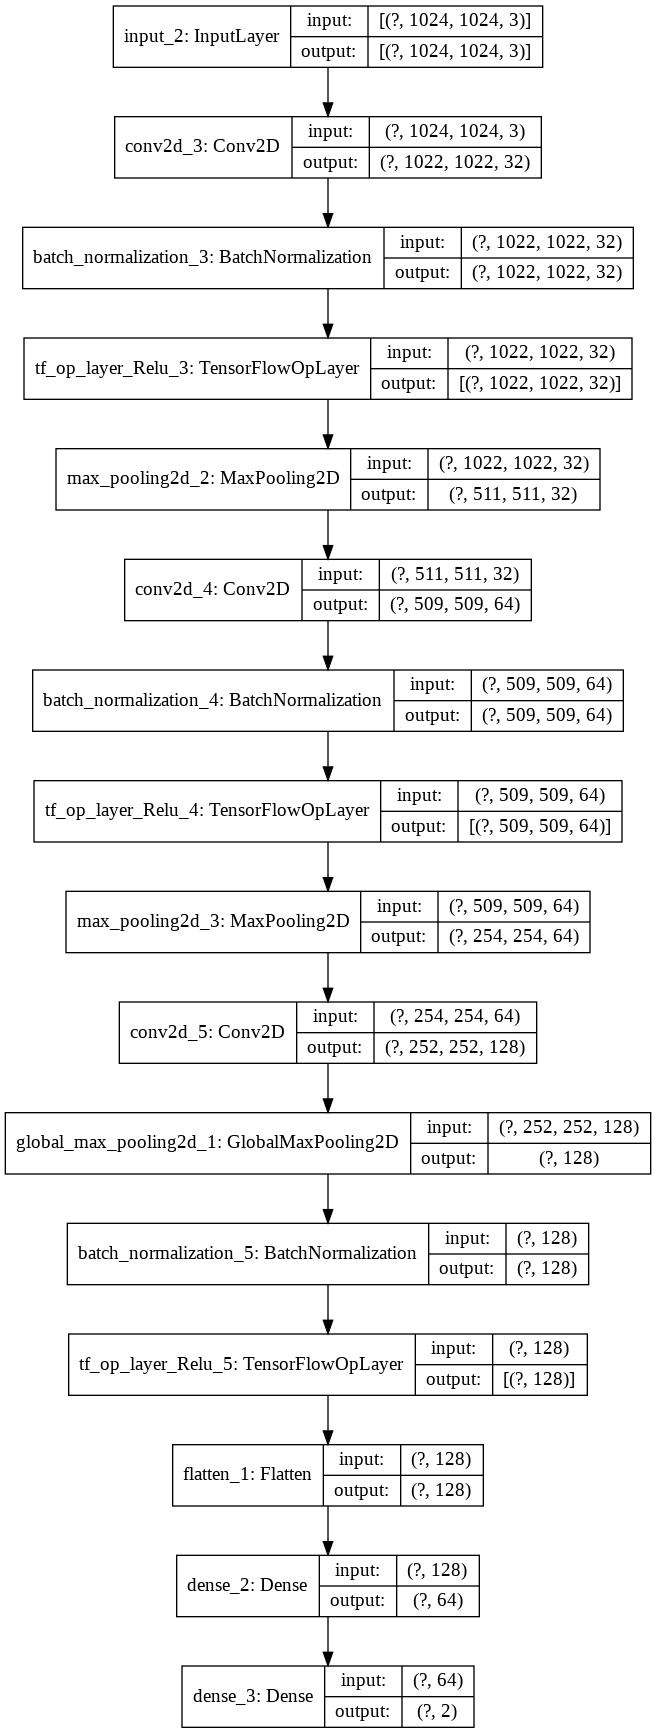

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
n_classes = 2

In [ ]:
#data generator class; yields batches of data for training/testing
class ImageGenerator():

    def __init__(self, directory, batch_size=16, shuffle=False, max_dimension=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_dimension = max_dimension
        
        self.image_paths = []
        self.class_labels = []
        
        #create list of image file paths and class target labels
        for class_label, class_dir in enumerate(listdir(directory)):
            self.image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]
            self.class_labels += [class_label for _ in listdir(path.join(directory,class_dir))]

        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self,img_path):
        
        #load image from path and convert to array
        #img = load_img(img_path, color_mode='rgb', interpolation='nearest')
        img = load_img(img_path, color_mode='rgb', interpolation='nearest')
        img = img_to_array(img)
        
        #downsample image if above allowed size if specified
        max_dim = max(img.shape) 
        if self.max_dimension:
            if max_dim > self.max_dimension:
                new_dim = tuple(d*self.max_dimension//max_dim for d in img.shape[1::-1])
                img = resize(img, new_dim)
            
        #scale image values
        img = preprocess_input(img)

        return img
    
    
    def _pad_images(self,img,shape):
        #pad images to match largest image in batch
        img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                    ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                          (0,0)),mode='constant',constant_values=0.)
        
        return img


    def __call__(self):
        #shuffle index
        if self.shuffle:
            np.random.shuffle(self.idx)
        
        #generate batches
        for batch in range(len(self)):

            batch_image_paths = self.image_paths[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]
            batch_class_labels = self.class_labels[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]

            batch_images = [self._load_image(image_path) for image_path in batch_image_paths]

            max_resolution = tuple(max([img.shape[i] for img in batch_images]) for i in range(2))
            batch_images = np.array([self._pad_images(image,max_resolution) for image in batch_images])

            yield batch_images, batch_class_labels

In [ ]:
# model.load_weights('insulators-v24_2.h5')

In [ ]:
#initialize our generators; specifying data directories, batch size, and dimension threshold

train_image_directory = 'transistor/train'
test_image_directory = 'transistor/validation'

n_classes = 2
batch_size = 16
max_dimension = 1024

#create generators for training and generating

train_generator = ImageGenerator(train_image_directory, batch_size=batch_size, shuffle=True, max_dimension=max_dimension)
test_generator = ImageGenerator(test_image_directory, batch_size=batch_size, max_dimension=max_dimension)

#convert generators into tf.data.Dataset objects for optimization with keras model fit method

train_dataset = tf.data.Dataset.from_generator(train_generator,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))

test_dataset = tf.data.Dataset.from_generator(test_generator,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))


#train and evaluate model
history = model.fit(train_dataset,validation_data=test_dataset,epochs=20,verbose=1,workers=2,max_queue_size=20)

Epoch 1/20
16/16 [==============================] - 32s 2s/step - loss: 0.9403 - accuracy: 0.6375 - val_loss: 0.4027 - val_accuracy: 0.8710
Epoch 2/20
16/16 [==============================] - 29s 2s/step - loss: 0.2717 - accuracy: 0.8884 - val_loss: 0.4313 - val_accuracy: 0.8710
Epoch 3/20
16/16 [==============================] - 29s 2s/step - loss: 0.1756 - accuracy: 0.9323 - val_loss: 0.4194 - val_accuracy: 0.8710
Epoch 4/20
16/16 [==============================] - 29s 2s/step - loss: 0.0869 - accuracy: 0.9841 - val_loss: 0.4086 - val_accuracy: 0.8710
Epoch 5/20
16/16 [==============================] - 29s 2s/step - loss: 0.0644 - accuracy: 0.9960 - val_loss: 0.4058 - val_accuracy: 0.8710
Epoch 6/20
16/16 [==============================] - 29s 2s/step - loss: 0.0497 - accuracy: 1.0000 - val_loss: 0.4144 - val_accuracy: 0.8710
Epoch 7/20
16/16 [==============================] - 29s 2s/step - loss: 0.0371 - accuracy: 0.9960 - val_loss: 0.4239 - val_accuracy: 0.8710
Epoch 8/20
16/16 [==

In [ ]:
#train_dataset

In [ ]:
#history = model.fit(train_dataset,validation_data=test_dataset,epochs=20)

In [ ]:
# from PIL import Image

# im = Image.open("/content/Mvtec_dataset/train/damaged/000_2.jpg")

In [ ]:
#history = model.fit(train_dataset,validation_data=test_dataset,epochs=2,verbose=1)

In [ ]:
#history = model.fit(train_dataset,validation_data=test_dataset,epochs=2,verbose=1)

In [ ]:
# Save the entire model to a HDF5 file
model.save('MVTec_Transistor_fine_tuning.h5')

Visualize

In [ ]:
import matplotlib.pyplot as plt

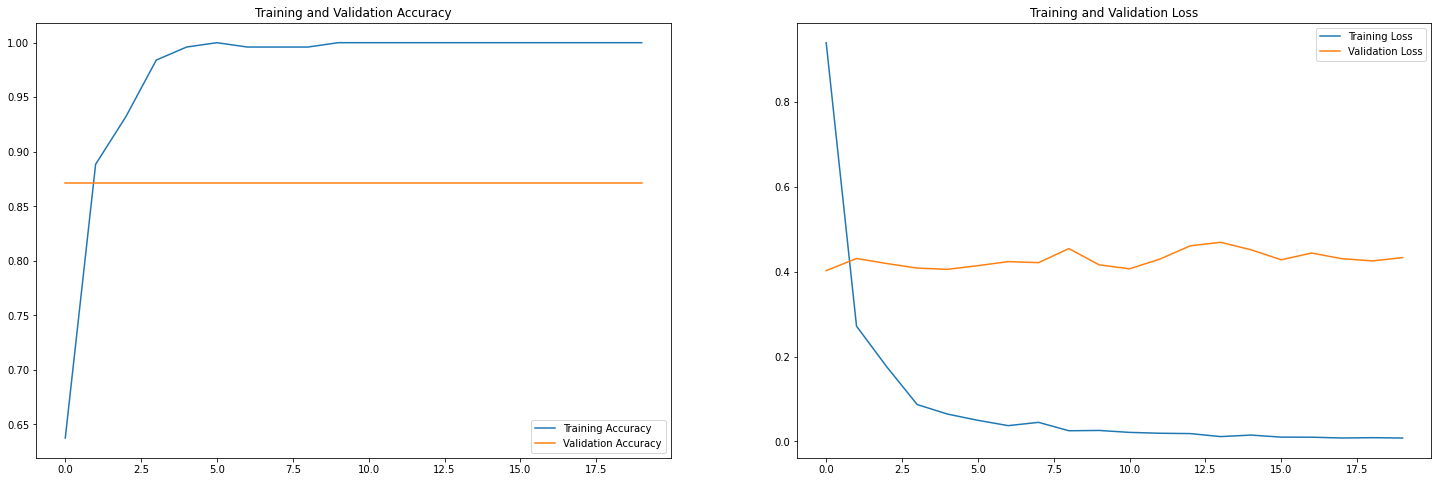

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)


#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')


plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
#plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(12)

# plt.figure(figsize=(25, 8))
# plt.subplot(1, 2, 1)


# #plt.plot(epochs_range, acc, label='Training Accuracy')
# #plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')


# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# #plt.plot(epochs_range, loss, label='Training Loss')
# #plt.plot(epochs_range, val_loss, label='Validation Loss')


# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')

# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

Evaluation

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_dataset, verbose=0)

#test_loss, test_acc = model.evaluate_generator(test_data_gen, verbose=0)

print('\nTest accuracy:', test_acc)



print('\nTest accuracy:', test_acc)

print('\nTest loss:', test_loss)













Instructions for updating:
Please use Model.evaluate, which supports generators.

Test accuracy: 0.8709677457809448

Test accuracy: 0.8709677457809448

Test loss: 0.4333721399307251


In [ ]:
## Make predictions on test data ##

### Let's make predictions on some images ###

test_generator.class_labels

predictions = model.predict_generator(test_dataset)

true_labels = test_generator.class_labels

predictions[0]

np.argmax(predictions[0])

test_generator.class_labels[0]

predictions[-1]

np.argmax(predictions[-1])

test_generator.class_labels[-1]



#test_dataset.classes

Instructions for updating:
Please use Model.predict, which supports generators.


1

In [ ]:
type(test_dataset)


tensorflow.python.data.ops.dataset_ops.FlatMapDataset

In [ ]:
#test_generator.image_paths

In [ ]:
test_generator.class_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[[ 0  8]
 [ 0 54]]


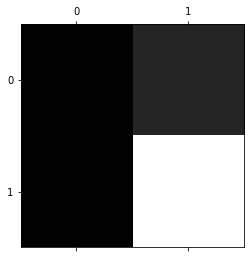

In [ ]:
## Confusion Matrix ##

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np



y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

y_pred





cm = confusion_matrix(y_true, y_pred)

print(cm)



plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['undamaged', 'damaged']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.00      0.00      0.00         8
     damaged       0.87      1.00      0.93        54

    accuracy                           0.87        62
   macro avg       0.44      0.50      0.47        62
weighted avg       0.76      0.87      0.81        62



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#train and evaluate model
#model.fit(train_dataset,epochs=10,verbose=1,workers=2,max_queue_size=20)